In [ ]:
import torch
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(SEED)

# Plots

In [ ]:
def plot_real_vs_predicted(trues, preds):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat
    
    plt.figure(figsize=(7,7))
    plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    plt.plot([trues.min(), trues.max()],
             [trues.min(), trues.max()],
             'r--', label='Perfect prediction')
    plt.colorbar(label="Absolute Error")
    plt.xlabel("Età reale")
    plt.ylabel("Età predetta")
    plt.title("Predicted vs True Age (colored by error)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_losses_zoom(train_losses, val_losses):
    x = np.arange(10, len(train_losses))
    plt.figure(figsize=(8,5))
    plt.plot(x, train_losses[10:], label="Train Loss")
    plt.plot(x, val_losses[10:], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)    
    plt.show()
    
def plot_losses_from_gridSearch(df_history):
    plt.figure(figsize=(8,5))
    plt.plot(df_history['epoch'][10:], df_history['train_loss'][10:], label='Train Loss')
    plt.plot(df_history['epoch'][10:], df_history['valid_loss'][10:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_results(trues, preds, train_losses, val_losses):
    trues_flat = trues.flatten()
    preds_flat = preds.flatten()
    errors = preds_flat - trues_flat

    # Imposta figure e assi
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 riga, 2 colonne

    # --- Plot 1: Predicted vs True ---
    sc = axes[0].scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
    axes[0].plot([trues.min(), trues.max()],
                 [trues.min(), trues.max()],
                 'r--', label='Perfect prediction')
    fig.colorbar(sc, ax=axes[0], label="Absolute Error")
    axes[0].set_xlabel("Età reale")
    axes[0].set_ylabel("Età predetta")
    axes[0].set_title("Predicted vs True Age (colored by error)")
    axes[0].legend()
    axes[0].grid(True)

    # --- Plot 2: Training vs Validation Loss (da epoch 10 in poi) ---
    x = np.arange(10, len(train_losses))
    axes[1].plot(x, train_losses[10:], label="Train Loss")
    axes[1].plot(x, val_losses[10:], label="Validation Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss (MSE o MAE)")
    axes[1].set_title("Training and Validation Loss over Epochs")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Datasets

In [50]:
DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

# Stratifica per quantili di età per avere distribuzioni simili nei set
y_bins = pd.qcut(y, q=10, labels=False, duplicates="drop")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED) #, stratify=y_bins

class MiRNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Porta a vettore colonna

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class MiRNANet(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=256, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((606, 1881), (606,), (152, 1881), (152,))

In [32]:
import numpy as np
print("y_train mean/std:", np.mean(y_train), np.std(y_train))
print("y_test mean/std:", np.mean(y_test), np.std(y_test))


y_train mean/std: 57.94884488448845 13.36202034778495
y_test mean/std: 57.6578947368421 12.40336608766786


# senza scaled

In [33]:
train_ds = MiRNADataset(X_train, y_train)
test_ds = MiRNADataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_ds, batch_size=32)

input_dim = X_train.shape[1]
model = MiRNANet(input_dim)

# Training setup
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
    factor=0.5,        # dimezza il learning rate
    patience=10        # aspetta 10 epoche senza miglioramenti
)

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 001 | Train Loss: 1217.5499 | Val Loss: 72.8114
Epoch 002 | Train Loss: 36.3872 | Val Loss: 17.1523
Epoch 003 | Train Loss: 19.1339 | Val Loss: 13.4328
Epoch 004 | Train Loss: 16.7602 | Val Loss: 18.9573
Epoch 005 | Train Loss: 16.2054 | Val Loss: 12.9949
Epoch 006 | Train Loss: 14.9266 | Val Loss: 11.8256
Epoch 007 | Train Loss: 18.0812 | Val Loss: 17.7812
Epoch 008 | Train Loss: 14.1203 | Val Loss: 13.6561
Epoch 009 | Train Loss: 13.3911 | Val Loss: 11.6061
Epoch 010 | Train Loss: 11.9575 | Val Loss: 10.9019
Epoch 011 | Train Loss: 12.3519 | Val Loss: 11.7352
Epoch 012 | Train Loss: 12.9221 | Val Loss: 11.5770
Epoch 013 | Train Loss: 12.6738 | Val Loss: 12.7202
Epoch 014 | Train Loss: 11.7149 | Val Loss: 10.3913
Epoch 015 | Train Loss: 11.9509 | Val Loss: 12.4920
Epoch 016 | Train Loss: 12.1624 | Val Loss: 11.1127
Epoch 017 | Train Loss: 11.6072 | Val Loss: 11.2905
Epoch 018 | Train Loss: 12.4346 | Val Loss: 10.9120
Epoch 019 | Train Loss: 11.4270 | Val Loss: 11.7509
Epoch 020 

In [34]:
model.eval()  # modalità evaluation
preds = []
trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds.append(outputs.numpy())
        trues.append(y_batch.numpy())

# Concatenazione dei batch
preds = np.vstack(preds).ravel()  # array 1D
trues = np.vstack(trues).ravel()  # array 1D

mae = mean_absolute_error(trues, preds)
r2 = r2_score(trues, preds)
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")

Test MAE: 11.49
Test R²: -0.343


In [35]:
model.eval()
preds_train, preds_test = [], []
with torch.no_grad():
    for Xb, _ in train_loader:
        preds_train.append(model(Xb).numpy())
    for Xb, _ in test_loader:
        preds_test.append(model(Xb).numpy())

preds_train = np.vstack(preds_train)
preds_test = np.vstack(preds_test)

# RMSE in anni
rmse_train = mean_absolute_error(y_train, preds_train)
rmse_test = mean_absolute_error(y_test, preds_test)

print("\n==============================")
print(f"RMSE train (anni): {rmse_train:.2f}")
print(f"RMSE test  (anni): {rmse_test:.2f}")
print("==============================\n")


RMSE train (anni): 12.82
RMSE test  (anni): 11.49



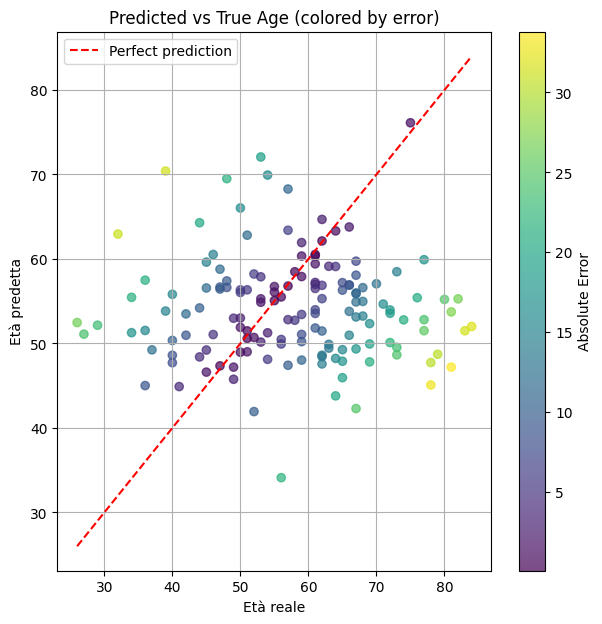

In [37]:
plot_real_vs_predicted(trues, preds)

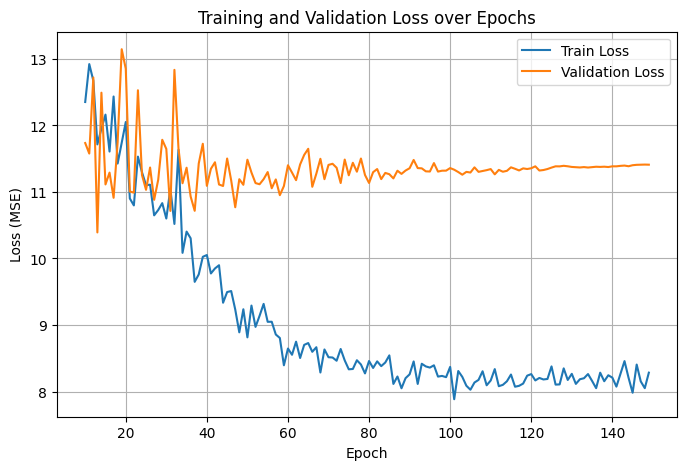

In [36]:
plot_losses_zoom(train_losses, val_losses)

# con scaled

In [44]:
############
# Scaler X #
############

scaler = "type_3"

if scaler == "type_1":
    # Scaler: caso 1
    X_train_log = np.log10(X_train + 1)
    X_test_log = np.log10(X_test + 1)
                              
    scaler_X = StandardScaler().fit(X_train_log)
    X_train_scaled = scaler_X.transform(X_train_log)
    X_test_scaled = scaler_X.transform(X_test_log)

elif scaler == "type_2":
    # Scaler: caso 2
    scaler_X = RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

elif scaler == "type_3":
    # Scaler: caso 3
    scaler_X = QuantileTransformer(output_distribution='normal', random_state=SEED).fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

############
# Scaler y #
############

"""scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

from sklearn.decomposition import PCA
pca = PCA(n_components=500, random_state=SEED).fit(X_train_scaled)
X_train_scaled = pca.transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

train_ds = MiRNADataset(X_train_scaled, y_train_scaled)
test_ds = MiRNADataset(X_test_scaled, y_test_scaled)"""

train_ds = MiRNADataset(X_train, y_train)
test_ds = MiRNADataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
model = MiRNANet(input_dim,256, 128, 0.2)

# Training setup
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
    factor=0.5,        # dimezza il learning rate
    patience=10        # aspetta 10 epoche senza miglioramenti
)

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (606). n_quantiles is set to n_samples.
  warnings.warn(


Epoch 001 | Train Loss: 385.3389 | Val Loss: 141.0261
Epoch 002 | Train Loss: 94.5332 | Val Loss: 43.8683
Epoch 003 | Train Loss: 63.9002 | Val Loss: 39.1125
Epoch 004 | Train Loss: 48.4578 | Val Loss: 25.4709
Epoch 005 | Train Loss: 37.4027 | Val Loss: 25.8861
Epoch 006 | Train Loss: 27.7418 | Val Loss: 24.1458
Epoch 007 | Train Loss: 27.7735 | Val Loss: 17.4430
Epoch 008 | Train Loss: 24.9841 | Val Loss: 17.6219
Epoch 009 | Train Loss: 22.8676 | Val Loss: 15.5927
Epoch 010 | Train Loss: 18.4929 | Val Loss: 15.0837
Epoch 011 | Train Loss: 18.3291 | Val Loss: 16.5093
Epoch 012 | Train Loss: 16.3371 | Val Loss: 13.5463
Epoch 013 | Train Loss: 15.5717 | Val Loss: 15.6038
Epoch 014 | Train Loss: 16.1940 | Val Loss: 14.9363
Epoch 015 | Train Loss: 14.7670 | Val Loss: 12.7485
Epoch 016 | Train Loss: 14.4810 | Val Loss: 15.3346
Epoch 017 | Train Loss: 15.9037 | Val Loss: 15.1225
Epoch 018 | Train Loss: 16.4510 | Val Loss: 15.2862
Epoch 019 | Train Loss: 13.3846 | Val Loss: 13.9700
Epoch 020 

In [45]:
# Valutazione
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)        
        all_preds.append(outputs.numpy())
        all_targets.append(y_batch.numpy())
        
preds_scaled = np.vstack(all_preds)
y_scaled = np.vstack(all_targets)

#preds_real = scaler_y.inverse_transform(preds_scaled)
#y_real = scaler_y.inverse_transform(y_scaled)
y_real, preds_real = y_scaled, preds_scaled

from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_real, preds_real)
r2 = r2_score(y_real, preds_real)

print(f"Test MAE (anni): {mae:.2f}")
print(f"R²: {r2:.3f}")

Test MAE (anni): 14.54
R²: -1.090


I risultati non sono sempre gli stessi =(

log + standard Scaler
    Test MAE (anni): 13.47
    R²: -0.692

RobustScaler
    Test MAE (anni): 11.10
    R²: -0.231

QuantileTransformer
    Test MAE (anni): 11.22
    R²: -0.248

In [46]:
model.eval()
preds_train, preds_test = [], []
with torch.no_grad():
    for Xb, _ in train_loader:
        preds_train.append(model(Xb).numpy())
    for Xb, _ in test_loader:
        preds_test.append(model(Xb).numpy())

preds_train = np.vstack(preds_train)
preds_test = np.vstack(preds_test)

# RMSE in anni
rmse_train = mean_absolute_error(y_train, preds_train)
rmse_test = mean_absolute_error(y_test, preds_test)

print("\n==============================")
print(f"RMSE train (anni): {rmse_train:.2f}")
print(f"RMSE test  (anni): {rmse_test:.2f}")
print("==============================\n")


RMSE train (anni): 14.33
RMSE test  (anni): 14.54



In [104]:
preds_real

array([[ 69.872574],
       [ 53.917957],
       [ 65.20615 ],
       [ 68.256004],
       [ 62.074337],
       [ 61.76163 ],
       [ 54.244884],
       [ 63.53654 ],
       [ 47.885357],
       [ 72.75774 ],
       [ 61.32532 ],
       [ 50.41816 ],
       [ 63.55592 ],
       [ 60.489655],
       [ 47.845367],
       [ 50.60966 ],
       [ 55.245476],
       [ 50.91368 ],
       [ 54.09758 ],
       [ 50.264038],
       [ 62.43946 ],
       [ 51.459118],
       [ 82.80096 ],
       [ 49.924416],
       [ 62.19993 ],
       [ 61.931496],
       [ 46.69118 ],
       [ 64.898865],
       [ 62.08084 ],
       [ 64.96658 ],
       [ 54.28155 ],
       [ 48.017807],
       [ 50.135582],
       [ 54.807537],
       [ 58.43454 ],
       [ 69.121254],
       [ 57.056484],
       [ 71.47349 ],
       [ 42.749825],
       [ 51.874775],
       [ 54.382652],
       [ 55.03462 ],
       [ 56.285587],
       [ 60.05907 ],
       [ 53.16592 ],
       [ 60.51118 ],
       [ 60.171284],
       [ 51.1

In [40]:
y_real

array([[51.      ],
       [45.      ],
       [59.      ],
       [50.      ],
       [54.      ],
       [51.      ],
       [67.      ],
       [48.      ],
       [42.      ],
       [70.      ],
       [55.      ],
       [34.      ],
       [66.      ],
       [67.      ],
       [58.      ],
       [68.      ],
       [66.      ],
       [64.      ],
       [42.      ],
       [59.      ],
       [69.      ],
       [49.      ],
       [50.      ],
       [69.      ],
       [68.      ],
       [57.      ],
       [63.      ],
       [64.      ],
       [62.      ],
       [57.      ],
       [39.      ],
       [47.      ],
       [83.      ],
       [72.      ],
       [39.      ],
       [74.      ],
       [36.      ],
       [61.      ],
       [62.      ],
       [56.      ],
       [67.      ],
       [49.      ],
       [81.      ],
       [34.      ],
       [50.      ],
       [25.999998],
       [56.      ],
       [66.      ],
       [64.      ],
       [72.      ],


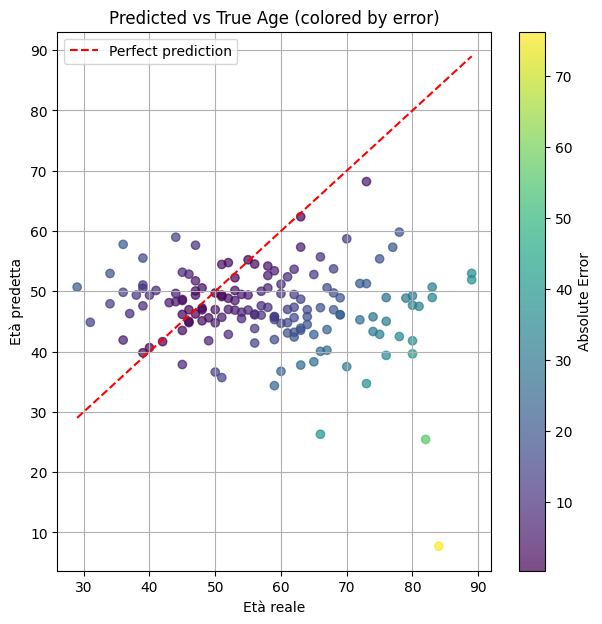

In [47]:
plot_real_vs_predicted(y_real, preds_real)

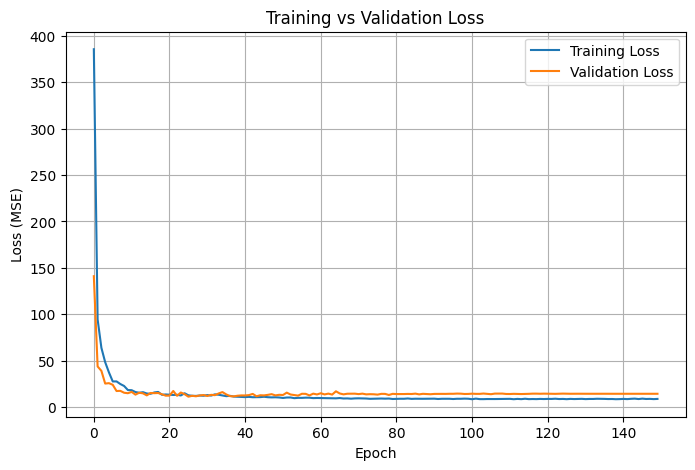

In [48]:
plot_losses(train_losses, val_losses)

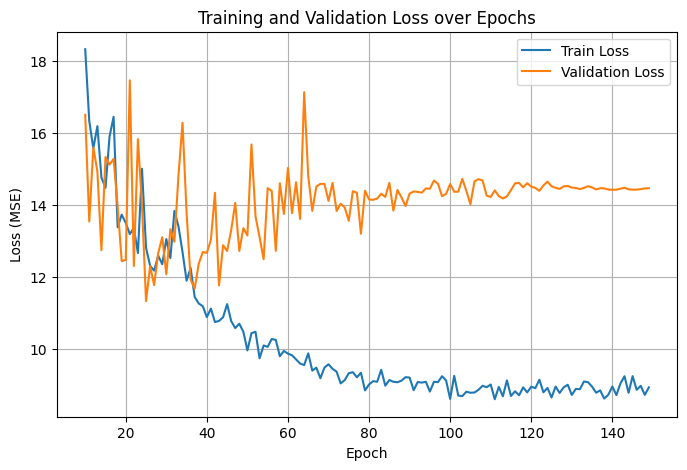

In [49]:
plot_losses_zoom(train_losses, val_losses)

In [63]:
trues_flat = y_real.flatten()
preds_flat = preds_real.flatten()
errors = preds_flat - trues_flat

In [64]:
len(trues_flat)

152

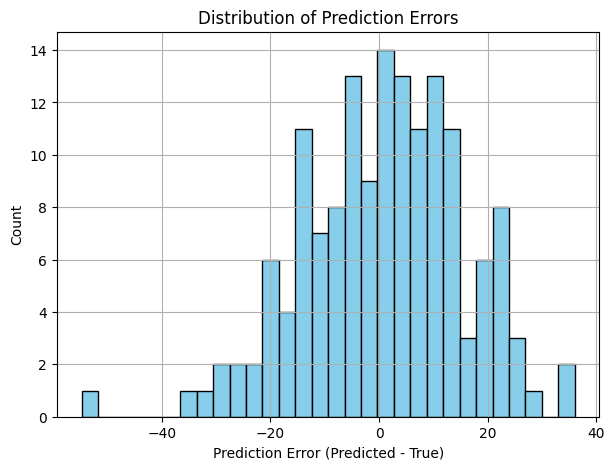

In [167]:
plt.figure(figsize=(7,5))
plt.hist(errors, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()

# GridSearch - senza scaled

In [57]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from skorch.callbacks import LRScheduler
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_test già ok come numpy array
X_train_sk = X_train.astype(np.float32)
X_test_sk = X_test.astype(np.float32)

# y deve essere 1D
y_train_sk = y_train.astype(np.float32).ravel()
y_test_sk = y_test.astype(np.float32).ravel()

  
class MiRNANet(nn.Module):
    def __init__(self, input_dim=1000, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet,
    module__input_dim=X_train_sk.shape[1],
    max_epochs=60,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    criterion=nn.L1Loss(),
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)

params = {
    #'module__hidden1': [128, 256],
    #'module__hidden2': [64, 128],
    'module__dropout': [0.2, 0.3, 0.5],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    'callbacks__lr_scheduler__patience': [15, 10, 5],
    'lr': [1e-3, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=3,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_sk, y_train_sk.ravel())

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

preds = best_model.predict(X_test_sk)
mae = mean_absolute_error(y_test_sk, preds)
r2 = r2_score(y_test_sk, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      908.4804      465.6113  0.0010  0.0419
      2      212.6196       71.0727  0.0010  0.0519
      3      104.1843       78.4250  0.0010  0.0618
      4       85.5093       41.6753  0.0010  0.0499
      5       58.5064       36.6910  0.0010  0.0409
      6       48.1248       23.8219  0.0010  0.0429
      7       41.6644       19.1523  0.0010  0.0484
      8       33.8206       32.2629  0.0010  0.0499
      9       34.8264       16.9523  0.0010  0.0560
     10       31.6035       19.5706  0.0010  0.0459
     11       25.2719       22.3745  0.0010  0.0434
     12       25.4075       24.5907  0.0010  0.0459
     13       23.3527       21.3132  0.0010  0.0474
     14       22.6338       16.2276  0.0010  0.0469
     15       21.7408       14.7030  0.0010  0.0424
     16       20.6762       20.2844  0.0010  0.0519
  

Best hyperparameters: {'lr': 0.001, 'module__hidden1': 256, 'module__hidden2': 64}
Test MAE: 11.00

In [65]:
############
# TOP MODELS
############
results = pd.DataFrame(gs.cv_results_)

# Ordina in base al punteggio (più alto = migliore, perché neg_mean_squared_error)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)

# Prendi top 5
top5 = results_sorted.head(5)

# Stampa i parametri e il punteggio
for i, row in top5.iterrows():
    print(f"Rank {i+1}: mean_test_score = {row['mean_test_score']:.4f}, params = {row['params']}")

Rank 2: mean_test_score = -464.7534, params = {'lr': 0.0005}
Rank 1: mean_test_score = -487.3991, params = {'lr': 0.001}


In [58]:
history = best_model.history
history[0].keys()

dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best', 'event_lr'])

In [54]:
import pandas as pd
pd.DataFrame(history)

,batches,epoch,train_batch_count,valid_batch_count,dur,train_loss,train_loss_best,valid_loss,valid_loss_best,event_lr
0,"[{'train_loss': 1731089.25, 'train_batch_size'...",1,16,4,0.064826,782605.478822,True,44204.884990,True,0.001
1,"[{'train_loss': 59121.45703125, 'train_batch_s...",2,16,4,0.053856,46405.212423,True,39512.848745,True,0.001
2,"[{'train_loss': 38818.140625, 'train_batch_siz...",3,16,4,0.059537,19933.316745,True,8470.725362,True,0.001
3,"[{'train_loss': 17682.87109375, 'train_batch_s...",4,16,4,0.055850,14802.473423,True,2379.237489,True,0.001
4,"[{'train_loss': 8458.482421875, 'train_batch_s...",5,16,4,0.072806,9449.571830,True,2009.774038,True,0.001
5,"[{'train_loss': 11583.1240234375, 'train_batch...",6,16,4,0.101728,10772.763753,False,3272.858811,False,0.001
6,"[{'train_loss': 6383.78515625, 'train_batch_si...",7,16,4,0.064834,7187.325276,True,1397.065370,True,0.001
7,"[{'train_loss': 6813.1103515625, 'train_batch_...",8,16,4,0.054495,6238.870545,True,2406.187332,False,0.001
8,"[{'train_loss': 5296.0712890625, 'train_batch_...",9,16,4,0.061834,6594.680574,False,3212.177298,False,0.001
9,"[{'train_loss': 5504.794921875, 'train_batch_s...",10,16,4,0.049867,5661.165967,True,1221.419532,True,0.001


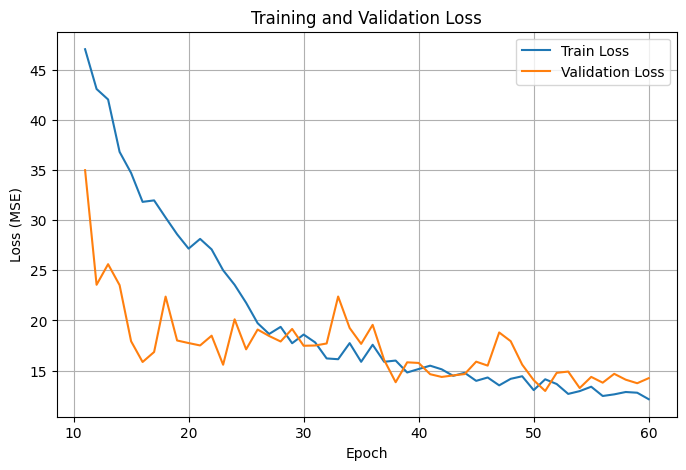

In [59]:
df_history = pd.DataFrame(best_model.history)
plot_losses_from_gridSearch(df_history)

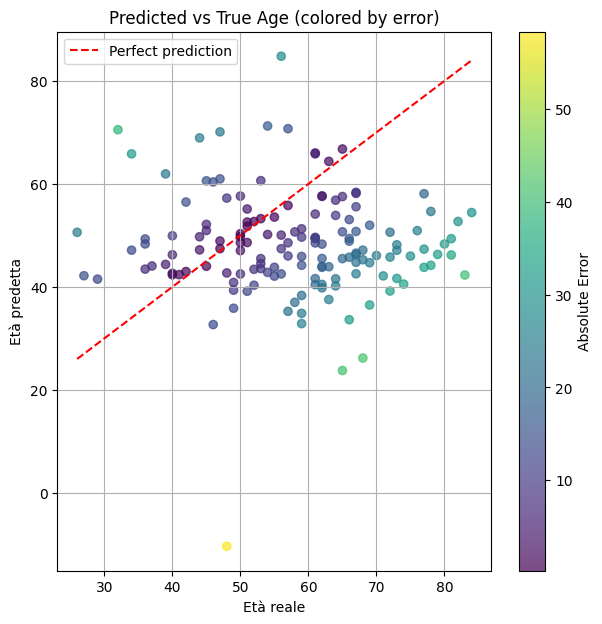

In [60]:
plot_real_vs_predicted(y_test_sk, preds)

# GridSearch - con scaler

In [303]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values

y_bins = pd.qcut(y, q=10, labels=False, duplicates="drop")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y_bins)

scaler = "type_1"

if scaler == "type_1":
    # Scaler: caso 1
    X_train_log = np.log10(X_train + 1)
    X_test_log = np.log10(X_test + 1)
                              
    scaler_X = StandardScaler().fit(X_train_log)
    X_train_scaled = scaler_X.transform(X_train_log)
    X_test_scaled = scaler_X.transform(X_test_log)

elif scaler == "type_2":
    # Scaler: caso 2
    scaler_X = RobustScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

elif scaler == "type_3":
    # Scaler: caso 3
    scaler_X = QuantileTransformer(output_distribution='normal', random_state=SEED).fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

"""y_train_scaled = y_train
y_test_scaled = y_test"""

#pip install umap-learn
"""import umap
n_features_umap = 400
reducer = umap.UMAP(n_neighbors=25, 
                    min_dist=0.1, 
                    n_components=n_features_umap,
                    random_state=SEED, 
                    metric='euclidean')
X_train_scaled = reducer.fit_transform(X_train_scaled)
X_test_scaled = reducer.transform(X_test_scaled)"""

# X_train, X_test già ok come numpy array
X_train_sk = X_train_scaled.astype(np.float32)
X_test_sk = X_test_scaled.astype(np.float32)


# y deve essere 1D
y_train_sk = y_train_scaled.astype(np.float32).ravel()
y_test_sk = y_test_scaled.astype(np.float32).ravel()

"""from sklearn.decomposition import PCA
pca = PCA(n_components=200, random_state=SEED).fit(X_train_sk)
X_train_sk = pca.transform(X_train_sk)
X_test_sk = pca.transform(X_test_sk)"""


class MiRNANet(nn.Module):
    def __init__(self, input_dim, hidden1=512, hidden2=256, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet,
    module__input_dim=X_train_sk.shape[1],
    max_epochs=150,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    criterion=nn.MSELoss,
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.8, 
             patience=20, 
             monitor='valid_loss',
             min_lr=1e-5
         ))
    ],
)

params = {
    #'module__hidden1': [128, 256, 512],
    #'module__hidden2': [64, 128, 256],
    #'module__dropout': [0.2, 0.3],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    #'callbacks__lr_scheduler__factor': [0.8, 0.6],
    #'callbacks__lr_scheduler__patience': [15, 10],
    'lr':[1e-3, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=2,# 3,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_sk, y_train_sk.ravel())

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

preds = best_model.predict(X_test_sk)
mae = mean_absolute_error(y_test_sk, preds)
r2 = r2_score(y_test_sk, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        1.2629        0.9956  0.0010  0.0908
      2        0.5139        1.0470  0.0010  0.0982
      3        0.2617        1.0452  0.0010  0.0943
      4        0.2262        1.0210  0.0010  0.0910
      5        0.1331        1.0490  0.0010  0.0930
      6        0.0823        1.0111  0.0010  0.0933
      7        0.0416        0.9932  0.0010  0.0743
      8        0.0188        1.0347  0.0010  0.0765
      9        0.0138        1.0112  0.0010  0.0799
     10        0.0130        1.0126  0.0010  0.0901
     11        0.0087        1.0199  0.0010  0.0990
     12        0.0091        1.0356  0.0010  0.0980
     13        0.0075        1.0246  0.0010  0.0821
     14        0.0070        1.0157  0.0010  0.0787
     15        0.0068        1.0216  0.0010  0.0798
     16        0.0073        1.0370  0.0010  0.0832
     

In [281]:
X_test_scaled

array([[-0.29287691, -0.24770842, -0.29628472, ..., -1.6203626 ,
         1.07086643, -0.50230465],
       [-1.41028518, -1.37184803, -1.41417808, ..., -0.75685187,
         0.58684966, -1.40903491],
       [ 2.87121823,  2.88357788,  2.88304547, ..., -0.6035767 ,
         1.2656277 ,  0.00550168],
       ...,
       [ 0.38871647,  0.36564917,  0.38668921, ..., -0.17090977,
        -1.38162891,  0.56021376],
       [ 0.97844678,  0.97771578,  0.94163032, ..., -0.93741938,
        -1.86053576, -0.0571069 ],
       [-0.97486332, -1.00545805, -0.9762868 , ..., -0.36830648,
         0.58959489, -0.19440871]])

In [297]:
# --- Predizioni sul test set ---
y_pred_scaled = best_model.predict(X_test_sk)  # valori standardizzati
"""y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # scala originale
y_true = scaler_y.inverse_transform(y_test_sk.reshape(-1, 1)).ravel()      # scala originale"""
y_true, y_pred = y_test_sk, y_pred_scaled

# --- Metriche ---
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE (anni): {mae:.2f}")
print(f"Test R²: {r2:.3f}")

Test MAE (anni): 10.76
Test R²: -0.014


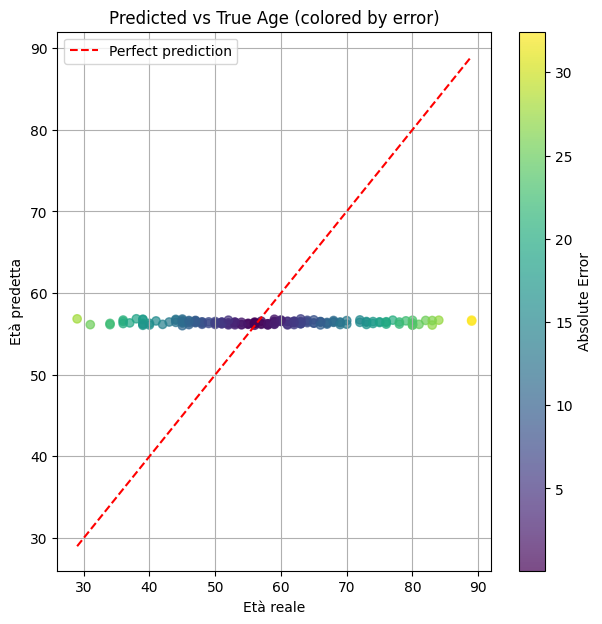

In [301]:
plot_real_vs_predicted(y_true, y_pred)

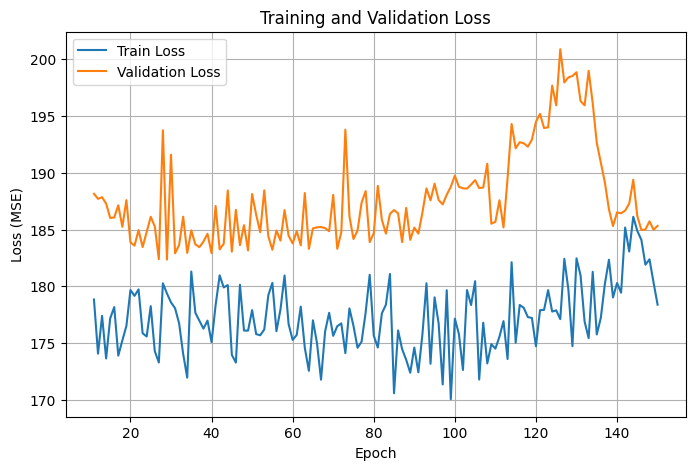

In [299]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(best_model.history)
plot_losses_from_gridSearch(df_history)